<a href="https://colab.research.google.com/github/RiccardoLeonelli2000/MlDtm/blob/main/mlprog_json.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install & Import Packages


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Bidirectional, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


# Load the Dataset and Comprension

In [3]:
!wget -O warehouse_sales.csv "https://data.montgomerycountymd.gov/api/views/v76h-r7br/rows.csv?accessType=DOWNLOAD"


df = pd.read_csv("warehouse_sales.csv")

print("Raw data head:")
print(df.head())
print("\nData types:")
print(df.dtypes)

missing_values = df.isnull().sum()

print("\nMissing Values Summary:")
print(missing_values)


--2025-05-04 08:36:02--  https://data.montgomerycountymd.gov/api/views/v76h-r7br/rows.csv?accessType=DOWNLOAD
Resolving data.montgomerycountymd.gov (data.montgomerycountymd.gov)... 52.206.140.199, 52.206.140.205, 52.206.68.26
Connecting to data.montgomerycountymd.gov (data.montgomerycountymd.gov)|52.206.140.199|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: ‘warehouse_sales.csv’

warehouse_sales.csv     [    <=>             ]  26.18M  4.16MB/s    in 6.3s    

2025-05-04 08:36:09 (4.17 MB/s) - ‘warehouse_sales.csv’ saved [27451860]

Raw data head:
   YEAR  MONTH                           SUPPLIER ITEM CODE  \
0  2020      1  REPUBLIC NATIONAL DISTRIBUTING CO    100009   
1  2020      1                          PWSWN INC    100024   
2  2020      1            RELIABLE CHURCHILL LLLP      1001   
3  2020      1          LANTERNA DISTRIBUTORS INC    100145   
4  2020      1               DIONYSOS IMPORTS INC    100293   

       

#Create a Date Column and Define the Target Variable



In [4]:
df['ds'] = pd.to_datetime(df['YEAR'].astype(str) + '-' + df['MONTH'].astype(str) + '-01')

df.rename(columns={'WAREHOUSE SALES': 'y'}, inplace=True)

df = df.sort_values('ds').reset_index(drop=True)
print("After date and target transformation:")
print(df[['ds','y']].head())


After date and target transformation:
          ds     y
0 2017-06-01   1.0
1 2017-06-01  11.0
2 2017-06-01   1.0
3 2017-06-01   0.0
4 2017-06-01   0.0


# Aggregate Data by Month


In [5]:
#feature selection - filter strategy
df_monthly = df.groupby('ds', as_index=False)['y'].sum()
df_monthly = df_monthly.sort_values('ds').reset_index(drop=True)
print("Monthly aggregated data:")
print(df_monthly.head())


Monthly aggregated data:
          ds          y
0 2017-06-01  379390.83
1 2017-07-01  316853.29
2 2017-08-01  382186.69
3 2017-09-01  305440.53
4 2017-10-01  303714.91


# Data Visualization




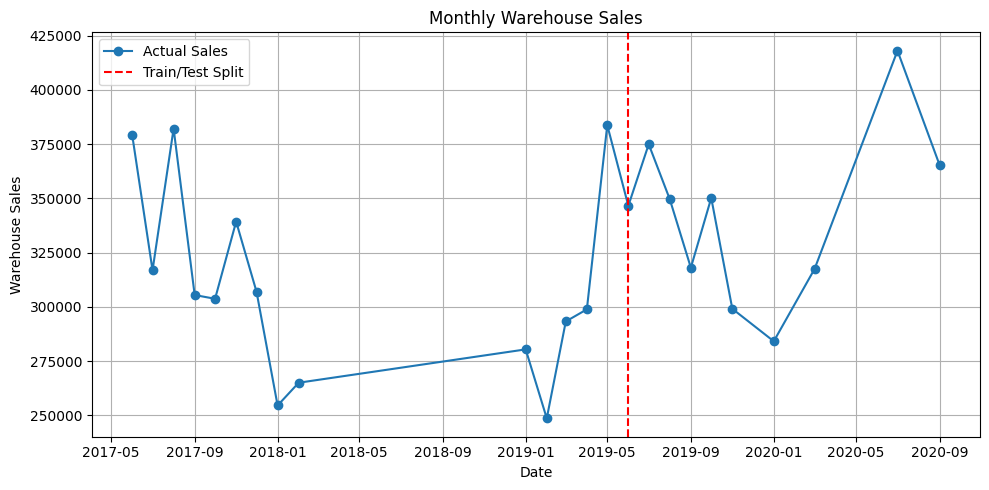

In [6]:
split_date = '2019-06-01'  # train/test
split_date_dt = pd.to_datetime(split_date)

# Plot the data
plt.figure(figsize=(10, 5))
plt.plot(df_monthly['ds'], df_monthly['y'], marker='o', label='Actual Sales')
plt.axvline(x=split_date_dt, color='red', linestyle='--', label='Train/Test Split')
plt.xlabel('Date')
plt.ylabel('Warehouse Sales')
plt.title('Monthly Warehouse Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


#RandomForest Forecasting


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/

RandomForest Errors -> RMSE: 42616.82, MAE: 31811.82


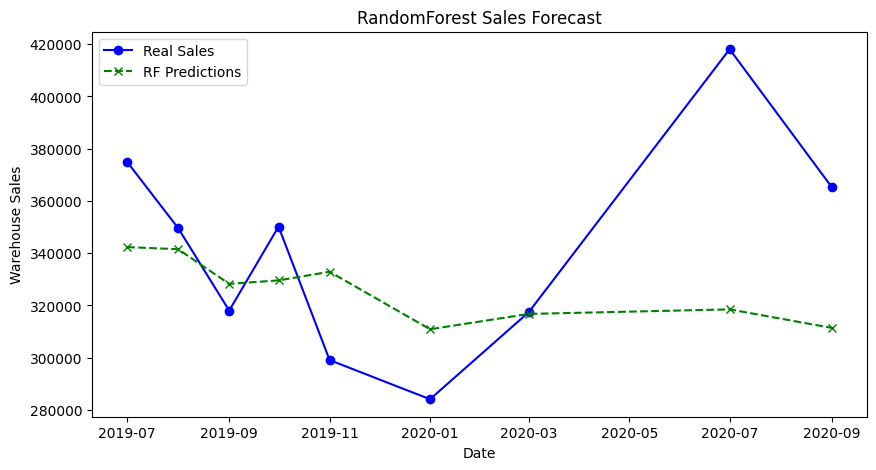

In [7]:
# Define the feature engineering function
def create_rf_features(df, lags, rolling_window):
    for lag in lags:
        df[f'lag_{lag}'] = df['y'].shift(lag)

    df[f'rolling_mean_{rolling_window}'] = df['y'].rolling(window=rolling_window).mean()
    df['month'] = df['ds'].dt.month
    df['year'] = df['ds'].dt.year
    df['quarter'] = df['ds'].dt.quarter
    df['sin_month'] = np.sin(2 * np.pi * df['month'] / 12)
    df['cos_month'] = np.cos(2 * np.pi * df['month'] / 12)

    # Drop listwise
    df = df.dropna()
    return df

# Apply feature engineering
df_features = create_rf_features(df=df_monthly, lags=[1,3,6], rolling_window=3)
feature_cols = [
    'lag_1', 'lag_3', 'lag_6', 'rolling_mean_3',
    'month', 'year', 'quarter', 'sin_month', 'cos_month'
]


# Train-Test Split
train_rf = df_features[df_features['ds'] <= split_date]
test_rf  = df_features[df_features['ds'] > split_date]

X_train_rf = train_rf[feature_cols]
y_train_rf = train_rf['y']

# Train RandomForest Model
params = {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
rf = RandomForestRegressor(**params, random_state=42)
rf.fit(X_train_rf, y_train_rf)

last_known = train_rf
future_dates = df_monthly[df_monthly['ds'] > split_date]['ds']

# Forecast ricorsivo
recursive_preds = []

for forecast_date in future_dates:
    month = forecast_date.month
    year = forecast_date.year
    quarter = (month - 1) // 3 + 1
    sin_month = np.sin(2 * np.pi * month / 12)
    cos_month = np.cos(2 * np.pi * month / 12)

    fallback = last_known['y'].mean() #media

    lag_1 = last_known.iloc[-1]['y']
    lag_3 = last_known.iloc[-3]['y']
    lag_6 = last_known.iloc[-6]['y']
    rolling_mean_3 = last_known['y'].iloc[-3:].mean()

    lag_features = {'lag_1': lag_1,'lag_3': lag_3,'lag_6': lag_6,'rolling_mean_3': rolling_mean_3}

    for feature_name in lag_features:
        if np.isnan(lag_features[feature_name]):
            lag_features[feature_name] = fallback

    features = np.array([[lag_features['lag_1'], lag_features['lag_3'], lag_features['lag_6'], lag_features['rolling_mean_3'],month, year, quarter,sin_month, cos_month]])

    prediction = rf.predict(features)[0]
    recursive_preds.append({'ds': forecast_date, 'y_pred': prediction})

    last_known = pd.concat([
        last_known,
        pd.DataFrame({'ds': [forecast_date], 'y': [prediction]})
    ])

df_preds_rf = pd.DataFrame(recursive_preds)
actuals = test_rf[['ds', 'y']]
df_preds_rf = df_preds_rf.merge(actuals, on='ds', how='left')

# Metrics
rmse_rf = np.sqrt(mean_squared_error(df_preds_rf['y'], df_preds_rf['y_pred']))
mae_rf = mean_absolute_error(df_preds_rf['y'], df_preds_rf['y_pred'])
print(f"RandomForest Errors -> RMSE: {rmse_rf:.2f}, MAE: {mae_rf:.2f}")

plt.figure(figsize=(10, 5))
plt.plot(df_preds_rf['ds'], df_preds_rf['y'], marker='o', label='Real Sales', color='blue')
plt.plot(df_preds_rf['ds'], df_preds_rf['y_pred'], marker='x', label='RF Predictions', color='green', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Warehouse Sales')
plt.title('RandomForest Sales Forecast')
plt.legend()
plt.show()


#LSTM Forecasting

Epoch 1/200


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.2826
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.2781
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.2738
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.2695
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.2654
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.2614
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.2576
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.2540
Epoch 9/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.2504
Epoch 10/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.2469
Epoch 11/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.2434
Epoch 12/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.2399
Epoch 13/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.2364
Epoch 14/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.2329
Epoch 15/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.2295
Epoch 16/200
1/1 ━━━━━━━━━━━━━━━━

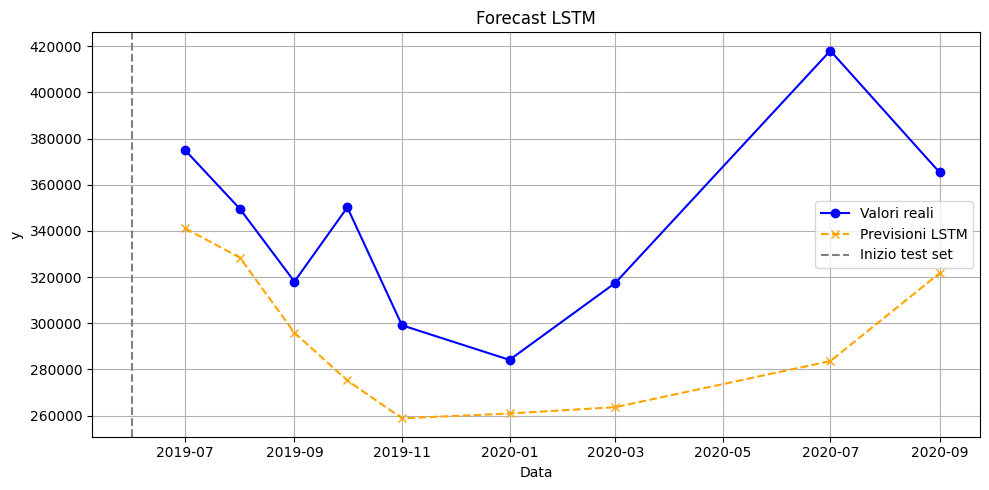

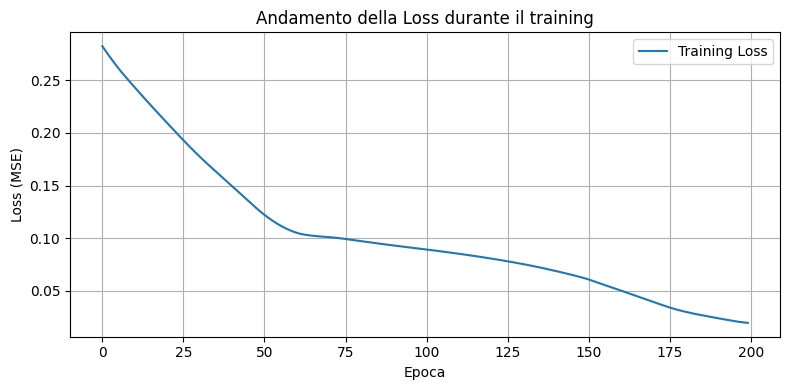

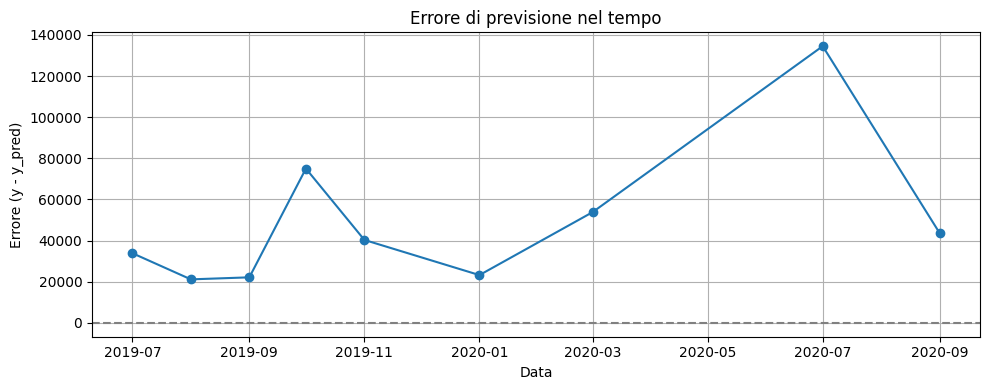

In [12]:
train = df_monthly[df_monthly['ds'] <= split_date]
test = df_monthly[df_monthly['ds'] > split_date]

series_train = train['y'].values.reshape(-1, 1)
series_test = test['y'].values.reshape(-1, 1)

# Normalizzazione
scaler = MinMaxScaler()
series_train_scaled = scaler.fit_transform(series_train)
series_test_scaled = scaler.transform(series_test)

# Crea le sequenze
def create_sequences(series, window_size=6):
    X, y = [], []
    for i in range(len(series) - window_size):
        X.append(series[i:i+window_size])
        y.append(series[i+window_size])
    return np.array(X), np.array(y)

window_size = 6
X_train, y_train = create_sequences(series_train_scaled, window_size)

# Modello LSTM
model = Sequential([LSTM(16, activation='relu', input_shape=(window_size, 1)),Dense(1)])
model.compile(optimizer='adam', loss='mse')
history = model.fit(X_train, y_train, epochs=200, verbose=1)

# Previsioni ricorsive + inversione scala
input_seq = list(series_train_scaled[-window_size:])
preds_scaled = []
preds = []

for i in range(len(series_test_scaled)):
    x_input = np.array(input_seq[-window_size:]).reshape((1, window_size, 1))
    y_scaled_pred = model.predict(x_input, verbose=0)[0][0]
    y_real_pred = scaler.inverse_transform([[y_scaled_pred]])[0][0]

    preds_scaled.append(y_scaled_pred)
    preds.append(y_real_pred)

    input_seq.append([y_scaled_pred])

# Valutazione
df_forecast = test.copy()
df_forecast['y_pred'] = preds

rmse_lstm = np.sqrt(mean_squared_error(df_forecast['y'], df_forecast['y_pred']))
mae_lstm = mean_absolute_error(df_forecast['y'], df_forecast['y_pred'])

print(f"LSTM RMSE: {rmse_lstm:.2f}")
print(f"LSTM MAE:  {mae_lstm:.2f}")

# Grafico
plt.figure(figsize=(10, 5))
plt.plot(df_forecast['ds'], df_forecast['y'], marker='o', label='Valori reali', color='blue')
plt.plot(df_forecast['ds'], df_forecast['y_pred'], marker='x', label='Previsioni LSTM', color='orange', linestyle='--')
plt.axvline(pd.to_datetime(split_date), color='gray', linestyle='--', label='Inizio test set')
plt.title('Forecast LSTM')
plt.xlabel('Data')
plt.ylabel('y')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.title('Andamento della Loss durante il training')
plt.xlabel('Epoca')
plt.ylabel('Loss (MSE)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(df_forecast['ds'], df_forecast['y'] - df_forecast['y_pred'], marker='o')
plt.axhline(0, color='gray', linestyle='--')
plt.title('Errore di previsione nel tempo')
plt.xlabel('Data')
plt.ylabel('Errore (y - y_pred)')
plt.grid(True)
plt.tight_layout()
plt.show()


#Final results



📊 Model Comparison:
RandomForest -> RMSE: 45578.39, MAE: 34735.33 (Split: 2019-06-01 00:00:00)
LSTM         -> RMSE: 56055.22, MAE: 48194.41 (Split: 2019-06-01 00:00:00)
Ensemble     -> RMSE: 46411.79, MAE: 36553.02 (Split: 2019-06-01 00:00:00)


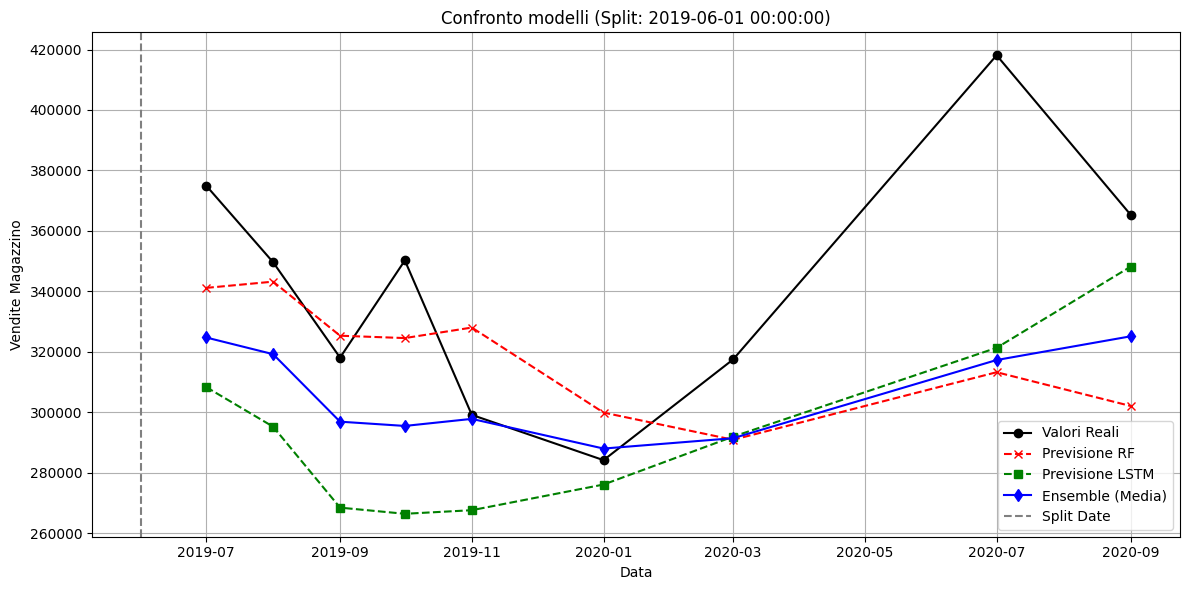

In [61]:
# ============================
# Unified Model Comparison Plot (Single Split Date)
# ============================
# Raccogli date e valori reali
common_dates = test_rf['ds'].reset_index(drop=True)
actual_sales = test_rf['y'].reset_index(drop=True)

# Previsioni RF e LSTM
pred_rf = df_preds_rf['y_pred'].reset_index(drop=True)
pred_lstm = df_forecast['y_pred'].reset_index(drop=True)

# Troncatura a lunghezza minima
min_len = min(len(common_dates), len(pred_rf), len(pred_lstm))
common_dates = common_dates[:min_len]
actual_sales = actual_sales[:min_len]
pred_rf_trimmed = pred_rf[:min_len]
pred_lstm_trimmed = pred_lstm[:min_len]

# Ensemble: media tra RF e LSTM
ensemble_pred = (pred_rf_trimmed + pred_lstm_trimmed) / 2

# Calcolo metriche
rmse_ens = np.sqrt(mean_squared_error(actual_sales, ensemble_pred))
mae_ens = mean_absolute_error(actual_sales, ensemble_pred)

# Stampa delle metriche
print("\n📊 Model Comparison:")
print(f"RandomForest -> RMSE: {rmse_rf:.2f}, MAE: {mae_rf:.2f} (Split: {split_date})")
print(f"LSTM         -> RMSE: {rmse_lstm:.2f}, MAE: {mae_lstm:.2f} (Split: {split_date})")
print(f"Ensemble     -> RMSE: {rmse_ens:.2f}, MAE: {mae_ens:.2f} (Split: {split_date})")

# ============================
# Unified Plot con Ensemble
# ============================

plt.figure(figsize=(12, 6))

# Valori reali
plt.plot(common_dates, actual_sales, marker='o', color='black', label='Valori Reali')

# Previsioni modelli
plt.plot(common_dates, pred_rf_trimmed, marker='x', linestyle='--', color='red', label='Previsione RF')
plt.plot(common_dates, pred_lstm_trimmed, marker='s', linestyle='--', color='green', label='Previsione LSTM')
plt.plot(common_dates, ensemble_pred, marker='d', linestyle='-', color='blue', label='Ensemble (Media)')

# Linea split
plt.axvline(pd.to_datetime(split_date), color='gray', linestyle='--', label='Split Date')

plt.title(f'Confronto modelli (Split: {split_date})')
plt.xlabel('Data')
plt.ylabel('Vendite Magazzino')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
